In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.offline as pyo
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.preprocessing import MinMaxScaler
#pyo.init_notebook_mode()

In [2]:
apps = pd.read_csv('data_cleaned.csv')

In [3]:
rev = pd.read_csv(r'C:\Users\User\Desktop\Università\BigDataAnalytics\ProgettoBDA\datasets\googleplaystore_user_reviews.csv')
rev['App'] = rev['App'].str.upper()

In [4]:
rev.drop_duplicates(subset = 'App', keep = 'first', inplace = True)

In [5]:
apps['Rating'].value_counts()

4.3    895
4.4    894
4.5    851
4.2    812
4.6    684
4.1    623
4.0    513
4.7    439
3.9    359
3.8    286
5.0    271
3.7    224
4.8    220
3.6    167
3.5    156
3.4    126
3.3    100
4.9     85
3.0     81
3.1     69
3.2     63
2.9     45
2.8     40
2.7     23
2.6     23
2.3     20
2.5     20
2.4     19
1.0     16
2.2     14
2.0     12
1.9     12
1.8      8
2.1      8
1.7      8
1.6      4
1.4      3
1.5      3
1.2      1
Name: Rating, dtype: int64

In [6]:
#remove the single record with Rating = 1.2 because the split into train and test doesn't support an y_class with only 1 record
apps = apps[apps['Rating'] != 1.2].reset_index(drop = True)

In [7]:
apps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8196 entries, 0 to 8195
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   App               8196 non-null   object 
 1   Rating            8196 non-null   float64
 2   Reviews           8196 non-null   int64  
 3   Size              8196 non-null   float64
 4   Installs          8196 non-null   object 
 5   Price             8196 non-null   float64
 6   Content Rating    8196 non-null   object 
 7   Last Updated      8196 non-null   object 
 8   Current Ver       8196 non-null   object 
 9   Android Ver       8196 non-null   object 
 10  Main_Genres       8196 non-null   object 
 11  Secondary_Genres  8196 non-null   object 
 12  Is_Family         8196 non-null   int64  
 13  Is_Game           8196 non-null   int64  
 14  Compatibility     8196 non-null   object 
 15  RTR               8196 non-null   float64
 16  Both_Stores       8196 non-null   int64  


In [8]:
#compute Sentiment Polarity Mean per apps
rev['SentimentPolarityMean'] = rev.groupby(['App'])['Sentiment_Polarity'].transform(lambda x: x.mean())

In [9]:
rev = rev.sort_values(by=['App', 'SentimentPolarityMean'], ascending=False)

In [10]:
#left join datasets
apps = pd.merge(apps, rev[['App', 'SentimentPolarityMean']], on = 'App', how = 'left')

In [11]:
#substitute missing value to preserve the type numerical variable
apps['SentimentPolarityMean'].fillna(999, inplace = True)

In [12]:
apps = apps.drop(columns = 'App')   #app name is not relevant as feature

In [13]:
apps['Last Updated']

0       14-07-2018
1       21-10-2017
2       24-07-2018
3       11-03-2018
4       17-11-2017
           ...    
8191    06-07-2018
8192    03-07-2018
8193    16-09-2014
8194    13-07-2018
8195    02-08-2018
Name: Last Updated, Length: 8196, dtype: object

In [14]:
#split Last Updated into Year, Month and Day
apps['YearUpdated'], apps['MonthUpdated'], apps['DayUpdated'] = pd.to_datetime(apps['Last Updated']).dt.year, pd.to_datetime(apps['Last Updated']).dt.month, pd.to_datetime(apps['Last Updated']).dt.day

In [15]:
apps = apps.drop(columns = 'Last Updated')   #Last Updated is redundant

In [16]:
categorical_attrs = ['Installs', 'Content Rating', 'Current Ver', 'Android Ver', 'Main_Genres',
       'Secondary_Genres', 'Compatibility']
numerical_attrs = ['Reviews', 'Size', 'Price', 'SentimentPolarityMean']

In [17]:
#scale numerical attributes into a range [0,1]
scaler = MinMaxScaler()
scaler.fit(apps[numerical_attrs])
apps[numerical_attrs] = scaler.transform(apps[numerical_attrs])

# Label Encoding for categorical attributes

In [18]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

In [19]:
apps.columns

Index(['Rating', 'Reviews', 'Size', 'Installs', 'Price', 'Content Rating',
       'Current Ver', 'Android Ver', 'Main_Genres', 'Secondary_Genres',
       'Is_Family', 'Is_Game', 'Compatibility', 'RTR', 'Both_Stores',
       'SentimentPolarityMean', 'YearUpdated', 'MonthUpdated', 'DayUpdated'],
      dtype='object')

In [21]:
#encode categorical attributes to deal with it
apps[categorical_attrs] = apps[categorical_attrs].apply(LabelEncoder().fit_transform)

In [22]:
class_name = 'Rating'
attributes = [col for col in apps.columns if col != class_name]
X = apps[attributes].values
y = apps[class_name]

In [23]:
from sklearn.model_selection import train_test_split

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [25]:
X_train.shape, y_train.shape

((5737, 18), (5737,))

# Model_8

In [32]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from math import sqrt
from scipy.stats import pearsonr, ks_2samp
from keras.models import load_model
from keras.utils import to_categorical
from keras.models import Sequential
from keras import Model
from keras.layers import Input
from keras.layers import Conv1D
from keras.layers import Dense
from keras.layers import MaxPool1D
from keras.layers import Flatten
from keras.layers import BatchNormalization
from keras.layers import Dropout
from matplotlib import pyplot
from keras.utils import plot_model
from keras.layers.merge import concatenate
from numpy import argmax

In [27]:
def seq_model(trainX, trainy):
    # one hot encode output variable
    trainy = to_categorical(trainy)
    model = Sequential([
        Conv1D(64, kernel_size=4, activation='tanh', padding = "same", input_shape = (trainX.shape[1],1)),
        BatchNormalization(),
        Flatten()
    ])
    model.compile(loss='mse', optimizer='adam', metrics=['mse'])
    return model

In [28]:
def cnn_model(trainX, trainy):
    # one hot encode output variable
    trainy = to_categorical(trainy)
    model = Sequential([
        Conv1D(64, kernel_size = 3, activation = 'relu', input_shape = (trainX.shape[1],1)),   
        Conv1D(128, kernel_size = 5, activation = 'relu'), 
        MaxPool1D(pool_size = 2),   
        Flatten(),
        Dense(64, activation = 'relu'),
        Dense(32, activation = 'relu'),
        Dense(24, activation = 'relu'),
        Dense(1)])
    model.compile(loss='mse', optimizer='adam', metrics=['mse'])
    return model

In [29]:
import os

In [35]:
#create directory for models
os.makedirs('models')

In [30]:
# fit and save models
n_members = 11
for i in range(n_members):
	if i in [0, 3, 5, 6, 7, 9]:
		# fit model
		model = seq_model(X_train, y_train)
		# save model
		filename = 'models/model_' + str(i + 1) + '.h5'
		model.save(filename)
	else:
		# fit model
		model = cnn_model(X_train, y_train)
		# save model
		filename = 'models/model_' + str(i + 1) + '.h5'
		model.save(filename)        
	print('>Saved %s' % filename)

>Saved models/model_1.h5
>Saved models/model_2.h5
>Saved models/model_3.h5
>Saved models/model_4.h5
>Saved models/model_5.h5
>Saved models/model_6.h5
>Saved models/model_7.h5
>Saved models/model_8.h5
>Saved models/model_9.h5
>Saved models/model_10.h5
>Saved models/model_11.h5


In [31]:
# load models from file
def load_all_models(n_models):
	all_models = list()
	for i in range(n_models):
		# define filename for this ensemble
		filename = 'models/model_' + str(i + 1) + '.h5'
		# load model from file
		model = load_model(filename)
		# add to list of members
		all_models.append(model)
		print('>loaded %s' % filename)
	return all_models

In [33]:
# define stacked model from multiple member input models
def define_stacked_model(members, trainy):
	# update all layers in all models to not be trainable
	for i in range(len(members)):
		model = members[i]
		for layer in model.layers:
			# make not trainable
			layer.trainable = False
			# rename to avoid 'unique layer name' issue
			layer._name = 'ensemble_' + str(i+1) + '_' + layer.name
	# define multi-headed input
	ensemble_visible = [model.input for model in members]
	# concatenate merge output from each model
	ensemble_outputs = [model.output for model in members]
	merge = concatenate(ensemble_outputs)
	output = Dense(1)(merge)
	model = Model(inputs=ensemble_visible, outputs=output)
	# plot graph of ensemble
	plot_model(model, show_shapes=True, to_file='model_graph.png')
	# compile
	model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
	return model

In [34]:
# create stacked model input dataset as outputs from the ensemble
def stacked_dataset(members, inputX):
	stackX = None
	for model in members:
		# make prediction
		yhat = model.predict(inputX, verbose=0)
		# stack predictions into [rows, members, probabilities]
		if stackX is None:
			stackX = yhat
		else:
			stackX = dstack((stackX, yhat))
	# flatten predictions to [rows, members x probabilities]
	stackX = stackX.reshape((stackX.shape[0], stackX.shape[1]*stackX.shape[2]))
	return stackX

In [35]:
# fit a stacked model
def fit_stacked_model(model, inputX, inputy):
	# prepare input data
	X = [inputX for _ in range(len(model.input))]
	# fit model
	model.fit(X, inputy, epochs=500, verbose=1, validation_split = 0.4)

In [36]:
# make a prediction with a stacked model
def predict_stacked_model(model, inputX):
	# prepare input data
	X = [inputX for _ in range(len(model.input))]
	# make prediction
	return model.predict(X, verbose=1)

In [43]:
# load all models
n_members = 11
members = load_all_models(n_members)
print('Loaded %d models' % len(members))
# define ensemble model
stacked_model = define_stacked_model(members, y_train)
# fit stacked model on test dataset
fit_stacked_model(stacked_model, X_test, y_test)

>loaded models/model_1.h5
>loaded models/model_2.h5
>loaded models/model_3.h5
>loaded models/model_4.h5
>loaded models/model_5.h5
>loaded models/model_6.h5
>loaded models/model_7.h5
>loaded models/model_8.h5
>loaded models/model_9.h5
>loaded models/model_10.h5
>loaded models/model_11.h5
Loaded 11 models
Epoch 1/500
47/47 [==============================] - 2s 51ms/step - loss: 1.8251 - accuracy: 0.0020 - val_loss: 0.3091 - val_accuracy: 0.0010
Epoch 2/500
47/47 [==============================] - 0s 10ms/step - loss: 0.3307 - accuracy: 0.0027 - val_loss: 0.2947 - val_accuracy: 0.0010
Epoch 3/500
47/47 [==============================] - 1s 11ms/step - loss: 0.3212 - accuracy: 0.0027 - val_loss: 0.8740 - val_accuracy: 0.0010
Epoch 4/500
47/47 [==============================] - 0s 10ms/step - loss: 0.3481 - accuracy: 0.0027 - val_loss: 0.6623 - val_accuracy: 0.0010
Epoch 5/500
47/47 [==============================] - 0s 10ms/step - loss: 0.3404 - accuracy: 0.0027 - val_loss: 0.2854 - val_ac

47/47 [==============================] - 0s 10ms/step - loss: 0.3652 - accuracy: 0.0027 - val_loss: 0.3926 - val_accuracy: 0.0010
Epoch 114/500
47/47 [==============================] - 1s 11ms/step - loss: 0.4258 - accuracy: 0.0027 - val_loss: 0.2856 - val_accuracy: 0.0010
Epoch 115/500
47/47 [==============================] - 1s 11ms/step - loss: 0.3759 - accuracy: 0.0027 - val_loss: 0.7734 - val_accuracy: 0.0010
Epoch 116/500
47/47 [==============================] - 1s 11ms/step - loss: 0.4233 - accuracy: 0.0027 - val_loss: 0.3740 - val_accuracy: 0.0010
Epoch 117/500
47/47 [==============================] - 0s 10ms/step - loss: 0.6252 - accuracy: 0.0027 - val_loss: 0.5336 - val_accuracy: 0.0010
Epoch 118/500
47/47 [==============================] - 0s 10ms/step - loss: 0.3268 - accuracy: 0.0027 - val_loss: 0.5504 - val_accuracy: 0.0010
Epoch 119/500
47/47 [==============================] - 0s 10ms/step - loss: 0.3689 - accuracy: 0.0027 - val_loss: 0.2854 - val_accuracy: 0.0010
Epoch 

Epoch 170/500
47/47 [==============================] - 1s 11ms/step - loss: 0.5287 - accuracy: 0.0027 - val_loss: 0.3548 - val_accuracy: 0.0010
Epoch 171/500
47/47 [==============================] - 1s 11ms/step - loss: 0.2867 - accuracy: 0.0027 - val_loss: 0.3650 - val_accuracy: 0.0010
Epoch 172/500
47/47 [==============================] - 1s 11ms/step - loss: 0.3411 - accuracy: 0.0027 - val_loss: 0.4217 - val_accuracy: 0.0010
Epoch 173/500
47/47 [==============================] - 0s 10ms/step - loss: 0.3281 - accuracy: 0.0027 - val_loss: 0.3563 - val_accuracy: 0.0010
Epoch 174/500
47/47 [==============================] - 0s 10ms/step - loss: 0.3811 - accuracy: 0.0027 - val_loss: 0.6827 - val_accuracy: 0.0010
Epoch 175/500
47/47 [==============================] - 0s 10ms/step - loss: 0.4418 - accuracy: 0.0027 - val_loss: 0.2999 - val_accuracy: 0.0010
Epoch 176/500
47/47 [==============================] - 0s 10ms/step - loss: 0.4145 - accuracy: 0.0027 - val_loss: 0.9470 - val_accuracy:

Epoch 227/500
47/47 [==============================] - 1s 11ms/step - loss: 0.4272 - accuracy: 0.0027 - val_loss: 0.2793 - val_accuracy: 0.0010
Epoch 228/500
47/47 [==============================] - 1s 11ms/step - loss: 0.3734 - accuracy: 0.0027 - val_loss: 0.3616 - val_accuracy: 0.0010
Epoch 229/500
47/47 [==============================] - 1s 11ms/step - loss: 0.3386 - accuracy: 0.0027 - val_loss: 0.2819 - val_accuracy: 0.0010
Epoch 230/500
47/47 [==============================] - 0s 10ms/step - loss: 0.3244 - accuracy: 0.0027 - val_loss: 0.4823 - val_accuracy: 0.0010
Epoch 231/500
47/47 [==============================] - 0s 10ms/step - loss: 0.4420 - accuracy: 0.0027 - val_loss: 0.3402 - val_accuracy: 0.0010
Epoch 232/500
47/47 [==============================] - 1s 11ms/step - loss: 0.3390 - accuracy: 0.0027 - val_loss: 0.5392 - val_accuracy: 0.0010
Epoch 233/500
47/47 [==============================] - 1s 11ms/step - loss: 0.3377 - accuracy: 0.0027 - val_loss: 0.6419 - val_accuracy:

Epoch 284/500
47/47 [==============================] - 1s 11ms/step - loss: 0.3144 - accuracy: 0.0027 - val_loss: 0.5691 - val_accuracy: 0.0010
Epoch 285/500
47/47 [==============================] - 1s 11ms/step - loss: 0.3751 - accuracy: 0.0027 - val_loss: 0.3368 - val_accuracy: 0.0010
Epoch 286/500
47/47 [==============================] - 1s 11ms/step - loss: 0.3486 - accuracy: 0.0027 - val_loss: 0.5537 - val_accuracy: 0.0010
Epoch 287/500
47/47 [==============================] - 0s 10ms/step - loss: 0.3092 - accuracy: 0.0027 - val_loss: 0.3329 - val_accuracy: 0.0010
Epoch 288/500
47/47 [==============================] - 1s 12ms/step - loss: 0.3599 - accuracy: 0.0027 - val_loss: 0.2919 - val_accuracy: 0.0010
Epoch 289/500
47/47 [==============================] - 1s 11ms/step - loss: 0.2814 - accuracy: 0.0027 - val_loss: 0.3368 - val_accuracy: 0.0010
Epoch 290/500
47/47 [==============================] - 0s 11ms/step - loss: 0.3627 - accuracy: 0.0027 - val_loss: 0.6709 - val_accuracy:

Epoch 341/500
47/47 [==============================] - 0s 10ms/step - loss: 0.3225 - accuracy: 0.0027 - val_loss: 0.2842 - val_accuracy: 0.0010
Epoch 342/500
47/47 [==============================] - 0s 10ms/step - loss: 0.3111 - accuracy: 0.0027 - val_loss: 0.3891 - val_accuracy: 0.0010
Epoch 343/500
47/47 [==============================] - 0s 10ms/step - loss: 0.3541 - accuracy: 0.0027 - val_loss: 0.4092 - val_accuracy: 0.0010
Epoch 344/500
47/47 [==============================] - 0s 10ms/step - loss: 0.3379 - accuracy: 0.0027 - val_loss: 3.3657 - val_accuracy: 0.0010
Epoch 345/500
47/47 [==============================] - 0s 10ms/step - loss: 0.5603 - accuracy: 0.0027 - val_loss: 0.2866 - val_accuracy: 0.0010
Epoch 346/500
47/47 [==============================] - 0s 10ms/step - loss: 0.3649 - accuracy: 0.0027 - val_loss: 0.2792 - val_accuracy: 0.0010
Epoch 347/500
47/47 [==============================] - 1s 11ms/step - loss: 0.3232 - accuracy: 0.0027 - val_loss: 0.3040 - val_accuracy:

Epoch 398/500
47/47 [==============================] - 1s 11ms/step - loss: 0.2928 - accuracy: 0.0027 - val_loss: 0.3193 - val_accuracy: 0.0010
Epoch 399/500
47/47 [==============================] - 0s 10ms/step - loss: 0.3760 - accuracy: 0.0027 - val_loss: 0.5152 - val_accuracy: 0.0010
Epoch 400/500
47/47 [==============================] - 0s 10ms/step - loss: 0.3642 - accuracy: 0.0027 - val_loss: 0.4282 - val_accuracy: 0.0010
Epoch 401/500
47/47 [==============================] - 1s 11ms/step - loss: 0.2993 - accuracy: 0.0027 - val_loss: 0.2808 - val_accuracy: 0.0010
Epoch 402/500
47/47 [==============================] - 1s 11ms/step - loss: 0.3126 - accuracy: 0.0027 - val_loss: 0.2808 - val_accuracy: 0.0010
Epoch 403/500
47/47 [==============================] - 0s 10ms/step - loss: 0.3942 - accuracy: 0.0027 - val_loss: 0.2932 - val_accuracy: 0.0010
Epoch 404/500
47/47 [==============================] - 0s 10ms/step - loss: 0.3361 - accuracy: 0.0027 - val_loss: 0.5972 - val_accuracy:

Epoch 455/500
47/47 [==============================] - 0s 10ms/step - loss: 0.3458 - accuracy: 0.0027 - val_loss: 0.5038 - val_accuracy: 0.0010
Epoch 456/500
47/47 [==============================] - 1s 11ms/step - loss: 0.3324 - accuracy: 0.0027 - val_loss: 0.8894 - val_accuracy: 0.0010
Epoch 457/500
47/47 [==============================] - 0s 10ms/step - loss: 0.5771 - accuracy: 0.0027 - val_loss: 0.3183 - val_accuracy: 0.0010
Epoch 458/500
47/47 [==============================] - 0s 10ms/step - loss: 0.3526 - accuracy: 0.0027 - val_loss: 0.8282 - val_accuracy: 0.0010
Epoch 459/500
47/47 [==============================] - 0s 10ms/step - loss: 0.4736 - accuracy: 0.0027 - val_loss: 0.3150 - val_accuracy: 0.0010
Epoch 460/500
47/47 [==============================] - 0s 10ms/step - loss: 0.3917 - accuracy: 0.0027 - val_loss: 0.8030 - val_accuracy: 0.0010
Epoch 461/500
47/47 [==============================] - 0s 10ms/step - loss: 0.3635 - accuracy: 0.0027 - val_loss: 0.3852 - val_accuracy:

In [44]:
# make predictions and evaluate
yhat = predict_stacked_model(stacked_model, X_test)

77/77 [==============================] - 0s 5ms/step


In [46]:
print('r on test %s' % pearsonr(np.array(y_test).ravel(), np.array(yhat.round(1)).ravel())[0])
print('KS on test %s' % ks_2samp(np.array(y_test).ravel(), np.array(yhat.round(1)).ravel())[0])
print('\n')
print('RMSE test %s' % sqrt(mse(np.array(y_test).ravel(), np.array(yhat.round(1)).ravel())))
print('MAE test %s' % mae(np.array(y_test).ravel(), np.array(yhat.round(1)).ravel()))

r on test 0.27199822786789873
KS on test 0.4192761285075234


RMSE test 0.573024493257835
MAE test 0.39215129778219365


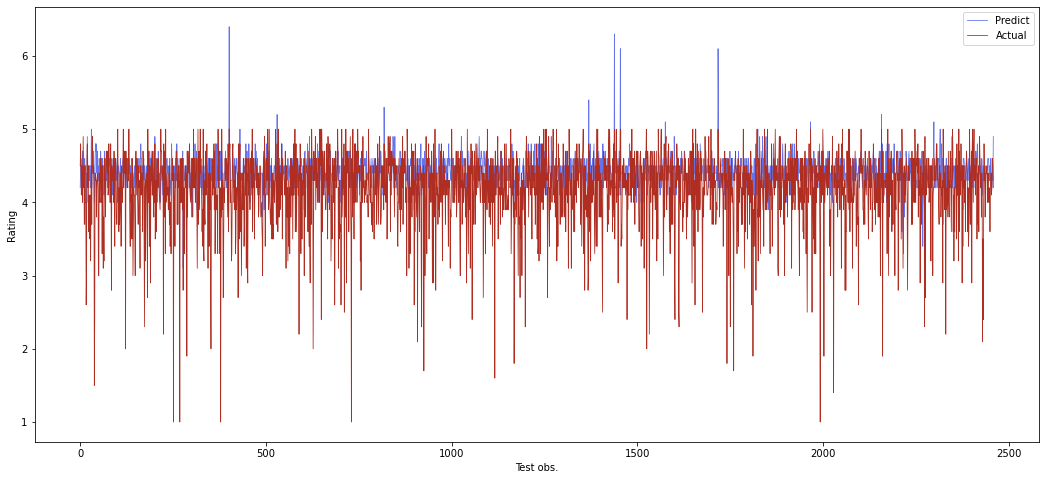

In [47]:
df4 = pd.DataFrame()

df4['RatingPredict'] = pd.Series(yhat.round(1).ravel())

df4['RatingActual'] = pd.Series(np.array(y_test).ravel())

plt.figure(figsize = (18, 8))
plt.plot(df4['RatingPredict'].index, df4['RatingPredict'].values, label = 'Predict', linewidth = 0.8, color = '#6473E9')
plt.plot(df4['RatingActual'].index, df4['RatingActual'].values, label = 'Actual', linewidth = 0.8, color = '#B02E21')
plt.legend()
plt.ylabel('Rating')
plt.xlabel('Test obs.')
plt.savefig('ActualPredictStacked.png')

df4.to_csv('PredictActualStacked.csv', index = False)

In [51]:
import plotly.express as px

fig = px.scatter(
    df4, x='RatingActual', y='RatingPredict', opacity=0.65,
    trendline='ols', trendline_color_override='darkblue'
)
fig.write_image('ActualPredictStacked2.png')
fig.show()